## This notebook is used for examining camera QE, read noise, full well and gain, by amplifier
This is based on Steve Ritz's notebook
https://github.com/smr456/raftexplorer/blob/master/rexplorer.ipynb

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy as sc
import textwrap
import pickle
from scipy.interpolate import CubicSpline
from shutil import copy
import pandas as pd

%matplotlib inline


In [2]:
#bay, run = 'R01 10861'.split()  #order 5, right after the 4 corner rafts
#bay, run = 'R11 10669'.split() #order 6, 
bay, run, order, vendor = 'R10 10517 7 ITL'.split() #used by Simon as path finder raft, 36 measurements per curve
#bay, run = 'R22 11351'.split() #order 11,

# steve's example notebook also looked at these runs in addition
#[10722, 11166,10928,10982]

destDir = '/project/shared/bxin/cam_as_built/%s/'%(bay)
if not os.path.exists(destDir):
    os.mkdir(destDir)

In [3]:
# define figure size parameters to make figures larger than default
figwidth=10
figheight=10

qepath = './'
if 1:
    srcDir = '/home/bxin/notebooks/raftexplorer/'
    filename='RaftRun'+str(run)+'.p'
    filepath = os.path.join(srcDir,filename)
    if not os.path.isfile('{}/{}'.format(destDir, filename)):
        print('copied pickle')
        copy(filepath, destDir)
    #qepath='/Users/ritz/LSST/CCD-analysis/raftResults/qefiles/'

    f=open(filepath,'rb')
    raft_name=pickle.load(f)
    res=pickle.load(f)
    ccd_list=pickle.load(f)
    file_list=pickle.load(f)
    fw=pickle.load(f)
    gains=pickle.load(f)
    #print(fw)
    f.close()

copied pickle


In [4]:
ccd_list

[('ITL-3800C-466', 'S00', 'LCA-13574-011'),
 ('ITL-3800C-040', 'S01', 'LCA-13574-011'),
 ('ITL-3800C-167', 'S02', 'LCA-13574-011'),
 ('ITL-3800C-223', 'S10', 'LCA-13574-041'),
 ('ITL-3800C-350', 'S11', 'LCA-13574-041'),
 ('ITL-3800C-438', 'S12', 'LCA-13574-041'),
 ('ITL-3800C-377', 'S20', 'LCA-13574-104'),
 ('ITL-3800C-446', 'S21', 'LCA-13574-104'),
 ('ITL-3800C-207', 'S22', 'LCA-13574-104')]

In [10]:
assert ccd_list[0][0][:3] == vendor
print(vendor)

ITL


In [11]:
#    print(raft_name[raft_name.index("RTM"):])
#    print(raft_name,res,ccd_list,file_list)
#    for ccd, noise in res.items(): 
#        print(ccd, noise,'\n') 
if (ccd_list[0][0][0:3]=='ITL'):
    imark='^'
    rcolor='b'
else:
    imark='o'
    rcolor='r'

In [12]:
raft_name

'LCA-11021_RTM-023'

In [13]:
for i in range(9):
    print(ccd_list[i][0])

ITL-3800C-466
ITL-3800C-040
ITL-3800C-167
ITL-3800C-223
ITL-3800C-350
ITL-3800C-438
ITL-3800C-377
ITL-3800C-446
ITL-3800C-207


copied ./ITL-3800C-466_QE.fits
copied ./ITL-3800C-040_QE.fits
copied ./ITL-3800C-167_QE.fits
copied ./ITL-3800C-223_QE.fits
copied ./ITL-3800C-350_QE.fits
copied ./ITL-3800C-438_QE.fits
copied ./ITL-3800C-377_QE.fits
copied ./ITL-3800C-446_QE.fits
copied ./ITL-3800C-207_QE.fits


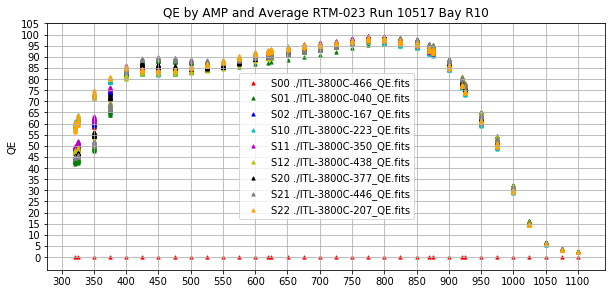

In [14]:
qesimple=np.zeros((100,17,9))
if 1:
    fig1=plt.figure(1,[figwidth,figheight])
    plt.subplot(211)
    plt.title('QE by AMP and Average '+raft_name[raft_name.index("RTM"):]+' Run '+run + ' Bay '+bay)
    plt.ylabel('QE')
    ax=fig1.gca()
    ax.grid(True)
    ax.set_xticks(np.arange(300, 1150, 50.))
    ax.set_yticks(np.arange(0, 110., 5.))
    cmap = { 0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'k',7:'gray',8:'orange',9:'darkslateblue',10:'coral',11:'darkblue',12:'darkred'}
    for i in range (0,9):
        filename=str(qepath+ccd_list[i][0]+'_QE.fits')
        filepath = os.path.join(srcDir,filename)
        #print(filename)
        try:
            if not os.path.isfile('{}/{}'.format(destDir, filename)):
                copy(filepath, destDir)
                print('copied %s'%filename)
        except FileNotFoundError:
            print('FileNotFoundError: {} '.format(filename))
            continue
        hdulist=fits.open(filepath)
#    hdulist.info()
        qedata=hdulist[1].data # 1 contains the qe curves, 2 contains the band qe. See hdulist.info()
        wavelength=qedata['WAVELENGTH']
        for iamp in range (1,17):
            if (iamp<10):
                samp='AMP0'+str(iamp)
            else:
                samp='AMP'+str(iamp) 
            #print("shape of qedata is ",qedata[samp].shape[0])
            #if (qedata[samp].shape[0]>8):
            #    goodqe= True 
                
            qesimple[:qedata[samp].shape[0],iamp,i]=qedata[samp]
            if iamp == 1:
                plt.scatter(wavelength,qedata[samp],10,cmap[i],imark, label='%s %s'%(ccd_list[i][1], filename))
            else:
                plt.scatter(wavelength,qedata[samp],10,cmap[i],imark)
    plt.legend()

In [15]:
if 1:
# there are more compact ways to take the mean of the non-zero segments, but this is clearest
    qeraft=np.zeros(len(wavelength))
    nseg=0
    for iccd in range(0,9):
        nseg+=np.count_nonzero(qesimple[0,1:17,iccd])
        print("for ccd ",iccd," number of nonzero segments is", np.count_nonzero(qesimple[0,1:17,iccd]))
        for iwave in range(0,len(wavelength)):
            for iamp in range (1,17):
                qeraft[iwave]+=qesimple[iwave,iamp,iccd]



for ccd  0  number of nonzero segments is 15
for ccd  1  number of nonzero segments is 16
for ccd  2  number of nonzero segments is 16
for ccd  3  number of nonzero segments is 16
for ccd  4  number of nonzero segments is 16
for ccd  5  number of nonzero segments is 16
for ccd  6  number of nonzero segments is 16
for ccd  7  number of nonzero segments is 16
for ccd  8  number of nonzero segments is 16


nseg = 143


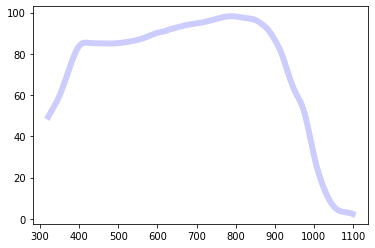

In [16]:
if 1:
    lambda1=np.arange(321,1100,1)           
    print('nseg = {}'.format(nseg))
    if 1:
        qeraft=qeraft/nseg
        qe=CubicSpline(wavelength, qeraft)
        qecurve=qe(lambda1)
        plt.plot(lambda1, qecurve,rcolor,linewidth=6,label='average',alpha=0.2)
        plt.show()


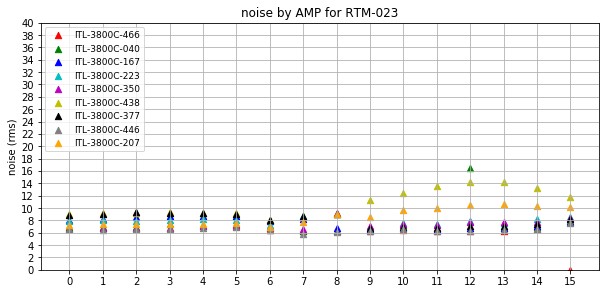

In [18]:
if 1:
    # now plot the noise
    fig2=plt.figure(2,[figwidth,figheight])
    plt.subplot(211)
    plt.title('noise by AMP for '+raft_name[raft_name.index("RTM"):])
    plt.ylabel('noise (rms)')
    ax=fig2.gca()
    ax.grid(True)
    ax.set_xticks(np.arange(0, 16, 1.))
    ax.set_yticks(np.arange(0, 50., 2.))
    ax.set_ylim([0.,40.])
    iseg=np.arange(0,16,1)
    icol=0
    for ccd, noise in res.items(): 
        #print(ccd)
        #print(noise)
        plt.scatter(iseg,noise,40,cmap[icol],imark,label=ccd)
        icol+=1
    plt.legend(loc='upper left',prop={'size':9})
    plt.show()
#

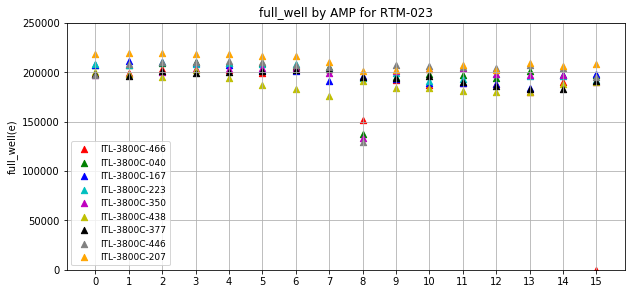

In [19]:
if 1:
    fig3=plt.figure(3,[figwidth,figheight])
    plt.subplot(211)
    plt.title('full_well by AMP for '+raft_name[raft_name.index("RTM"):])
    plt.ylabel('full_well(e)')
    ax=fig3.gca()
    ax.grid(True)
    ax.set_xticks(np.arange(0, 16, 1.))
    #ax.set_yticks(np.arange(0, 50., 2.))
    ax.set_ylim([0.,250000.])
    iseg=np.arange(0,16,1)
    icol=0
    for ccd, fullwell in fw.items(): 
        plt.scatter(iseg,fullwell,40,cmap[icol],imark,label=ccd)
        icol+=1
    plt.legend(loc='lower left',prop={'size':9})
    plt.show()
#

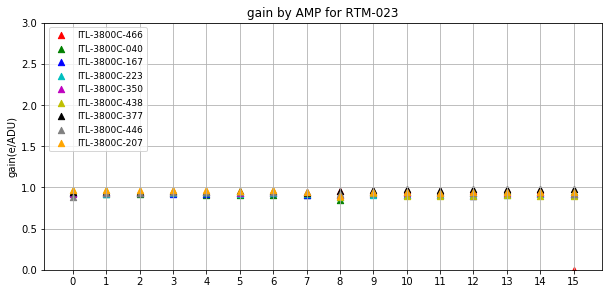

In [20]:
if 1:
    fig4=plt.figure(4,[figwidth,figheight])
    plt.subplot(211)
    plt.title('gain by AMP for '+raft_name[raft_name.index("RTM"):])
    plt.ylabel('gain(e/ADU)')
    ax=fig4.gca()
    ax.grid(True)
    ax.set_xticks(np.arange(0, 16, 1.))
    #ax.set_yticks(np.arange(0, 50., 2.))
    ax.set_ylim([0.,3.])
    iseg=np.arange(0,16,1)
    icol=0
    for ccd, gain in gains.items(): 
        plt.scatter(iseg,gain,40,cmap[icol],imark,label=ccd)
        icol+=1
    plt.legend(loc='upper left',prop={'size':9})
    plt.show()



#    return qecurve,qesimple,raft_name[raft_name.index("RTM"):]

### If everything looks fine, write this raft to the installation record

In [46]:
raftInstallFile = 'raftInstall.csv'
dd = pd.read_csv(raftInstallFile, index_col=0)
dd.rtm.loc[bay] = raft_name[-7:]
dd.order.loc[bay] = order
dd.vendor.loc[bay] = vendor
dd.to_csv(raftInstallFile)

In [47]:
dd

,rtm,order,vendor
R00,NaN,NaN,NaN
R01,NaN,NaN,NaN
R02,NaN,NaN,NaN
R03,NaN,NaN,NaN
R04,NaN,NaN,NaN
R10,RTM-023,7,ITL
R11,NaN,NaN,NaN
R12,NaN,NaN,NaN
R13,NaN,NaN,NaN
R14,NaN,NaN,NaN
